In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score
)
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(rc = {'figure.figsize':(9,6)})
print(sns.__version__)

0.13.2


# 1. Exploratory Data Analysis

In [2]:
df = pd.read_csv('online_retail_II.csv')
df = df.rename(columns={'Customer ID':'Customer_ID'})
df.head()

df_without_canceled = df[df['Invoice'].apply(lambda x: x[0]) != 'C']
df_canceled = df[df['Invoice'].apply(lambda x: x[0]) == 'C']

In [3]:
data_description = {'Invoice':'Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter "c", it indicates a cancellation.', 
                    'StockCode':'Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.', 
                    'Description': 'Product (item) name. Nominal.', 'Quantity': 'The quantities of each product (item) per transaction. Numeric.', 'Customer ID': 'Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.', 'InvoiceDate': 'Invoice date and time. Numeric. The day and time when a transaction was generated.', 
                    'Price': 'Unit price. Numeric. Product price per unit in sterling (Â£).', 'Counrty': 'Country name. Nominal. The name of the country where a customer resides.'}

df['Country'].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia',
       'Czech Republic', 'European Community'], dtype=object)

In [4]:
customers_not_canceled = df_without_canceled.groupby('Customer_ID')['StockCode'].apply(list).reset_index().rename(columns={'StockCode':'Purchased'})
customer_canceled = df_canceled.groupby('Customer_ID')['StockCode'].apply(list).reset_index().rename(columns={'StockCode':'Canceled'})
customers_not_canceled['Unique_Purchased'] = customers_not_canceled['Purchased'].apply(lambda x: list(set(x)))
customers_not_canceled['Total_Order_Size'] = customers_not_canceled['Purchased'].str.len()
customers_not_canceled['Unique_Items'] = customers_not_canceled['Unique_Purchased'].str.len()

customers = customers_not_canceled.merge(customer_canceled, how='outer')
customers = customers[['Customer_ID', 'Canceled', 'Purchased', 'Unique_Purchased', 'Total_Order_Size', 'Unique_Items']]
customers['Canceled'] = customers['Canceled'].apply(lambda x: x if isinstance(x, list) else [])

customers.head()

,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items
0,12346.0,"[ADJUST, M, M, M, M, M, M, M, M, M, M, D, TEST...","[TEST001, TEST001, TEST001, TEST001, TEST002, ...","[20682, 20685, TEST001, 22688, 15056BL, 48187,...",34.0,27.0
1,12347.0,[],"[22698, 22699, 20985, 22418, 22422, 51014A, 51...","[23084, 23171, 21976, 20665, 21832, 23172, 234...",253.0,126.0
2,12348.0,[],"[21213, 84991, 22951, 84992, 21977, 84988, 849...","[21967, 84988, 22952, 84991, 21211, 21725, 217...",51.0,25.0
3,12349.0,"[22072, 20914, 21231, 21232, 20747]","[22554, 22555, 22553, 16156S, 22052, 22048, 22...","[21533, 22740, 22326, 23253, 22072, 84078A, 23...",175.0,138.0
4,12350.0,[],"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...","[79066K, 22551, 79191C, 84086C, 22557, 21915, ...",17.0,17.0


In [5]:
customers.describe()

df_without_canceled['money_recieved'] = df_without_canceled['Price'].astype(float) * df['Quantity'].astype(float)
df_canceled['money_back'] = df_canceled['Price'].astype(float) * df['Quantity'].astype(float)
money_recieved = df_without_canceled.groupby('Customer_ID', as_index=False).agg(money_recieved = ('money_recieved', 'sum'))
money_back = df_canceled.groupby('Customer_ID', as_index=False).agg(money_back = ('money_back','sum')).abs()
money = money_recieved.merge(money_back, how='outer')

money.head()

,Customer_ID,money_recieved,money_back
0,12346.0,77556.46,77621.14
1,12347.0,5633.32,NaN
2,12348.0,2019.40,NaN
3,12349.0,4428.69,24.15
4,12350.0,334.40,NaN


In [6]:
customers_money = customers.merge(money, how='outer')
customers_money['money_back'] = customers_money['money_back'].fillna(0)
customers_money['money_diff'] = customers_money['money_recieved'] - customers_money['money_back']

customers_money.sort_values('money_recieved', ascending=False).head()

,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff
5756,18102.0,"[D, 85014C, 15056P, M, 22692, 22691, D, D, M, M]","[21329, 21252, 21100, 21033, 20711, 21410, 214...","[22839, 22845, 22115, 21309, 23544, 22287, 209...",1058.0,382.0,608821.65,10606.43,598215.22
2300,14646.0,"[D, 22356, 20725, 21558, 22634, 22635, 21432, ...","[22271, 22078, 22082, 22149, 22294, 20914, 359...","[21976, 20665, 22326, 22697, 22158, 22028, 227...",3854.0,962.0,528602.52,5260.45,523342.07
1810,14156.0,"[21232, 84782C, 20914, 22061, 84782A, 21874, 2...","[84050, 47568, 84782A, 84782C, 21232, 21231, 2...","[21976, 21499, 22697, 22731, 85216, 22269, 226...",4048.0,1446.0,313946.37,17381.68,296564.69
2565,14911.0,"[21053, 21652, 21259, 21249, 21843, 22183, 218...","[35751C, 72739B, 22114, 22212, 21523, 48187, 4...","[21976, 21499, 85006, 22697, 90201A, 22731, 85...",11247.0,2550.0,295972.63,25724.10,270248.53
5104,17450.0,"[82482, 71459, 82494L, 71477, 21733, 85123A, 2...","[22357, 21770, 22612, 21621, 46000M, 21622, 21...","[21755, 22845, 21364, 23243, 22774, 21272, 232...",425.0,145.0,246973.09,13393.70,233579.39


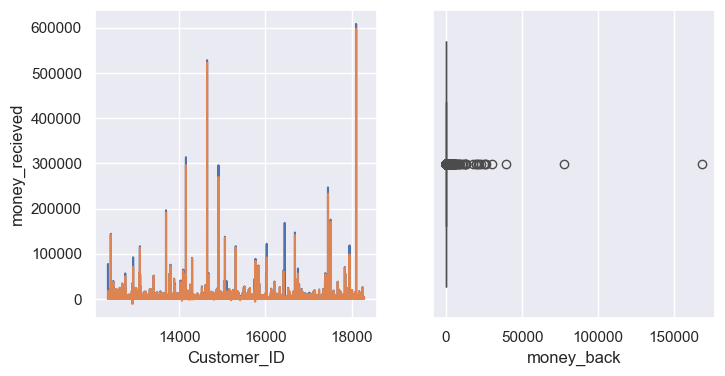

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
sns.lineplot(x=customers_money['Customer_ID'], y=customers_money['money_recieved'],ax=ax1)
sns.lineplot(x=customers_money['Customer_ID'], y=customers_money['money_diff'],ax=ax1)
sns.boxplot(x=customers_money['money_back'])
plt.show()

We see that generally the graphs for the money recieved from all user orders and the money recieved only from the non-cancelled orders (|money_recieved| - |money_back|) are similar. This indicates that the majority of users cancel orders when they either accidently order it or genuinly realize that they do not need it. Therefore, for the mojority of the users the behaiviour in the difference between |money_recieved|,|money_back| does not seem fraudulent

1. However, there are some suspicious users, with an amount of canceled orders easily detected with a naked eye
2. Further analysis for |money_recieved| - |money_back| is needed

In [8]:
customers_money.describe()

,Customer_ID,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff
count,5942.000000,5881.000000,5881.000000,5881.000000,5942.000000,5881.000000
mean,15316.500000,136.986907,81.949838,3017.076888,184.304408,2841.241848
std,1715.451981,353.779018,116.475103,14734.128619,2698.074290,14036.711170
min,12346.000000,1.000000,1.000000,0.000000,0.000000,-10953.500000
25%,13831.250000,21.000000,19.000000,347.800000,0.000000,334.400000
50%,15316.500000,53.000000,45.000000,897.620000,0.000000,862.420000
75%,16801.750000,142.000000,103.000000,2304.180000,32.530000,2216.800000
max,18287.000000,12890.000000,2550.000000,608821.650000,168478.600000,598215.220000


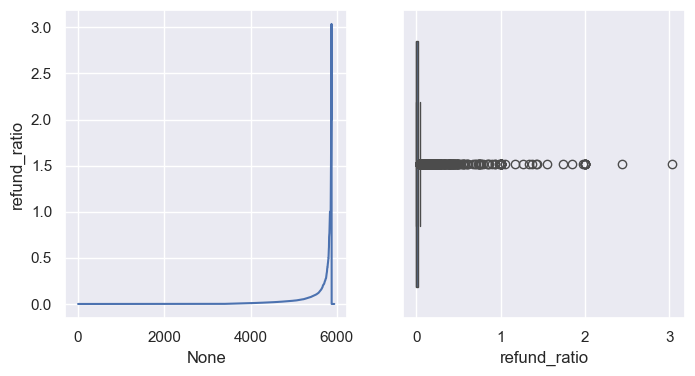

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
customers_money['refund_ratio'] = customers_money['money_back']/customers_money['money_recieved']
customers_money = customers_money.sort_values('refund_ratio').reset_index().fillna(0)
sns.lineplot(x=customers_money.index,y=customers_money['refund_ratio'], ax=ax1)
sns.boxplot(x=customers_money['refund_ratio'], ax=ax2)
plt.show()

We see a large peak in the refund ratio whereas for most of the users the refund is monotone and relatively small. Values higher than 1 probably come from canceleaion of orders created before the report period. Therefore, money_recieved from such users is 0, money_back != 0

1. To analyze fraudulent activity it may be important to highlight the cancelation of the orders created before the report period and analyse them separetly

In [10]:
customers_money['refund_ratio'].quantile(0.75)

np.float64(0.01604220209149493)

We have a very small value for Q3, it should not be used directly to estimate outliers. Why?
1. The expected value of the refund ratio for users that have recently joined the service is low, while for long time users it can be suffuciently larger
2. We divide the users into 4 categories: new, moderate_time, long_time and zero_days

<Axes: xlabel='None', ylabel='time_using_service'>

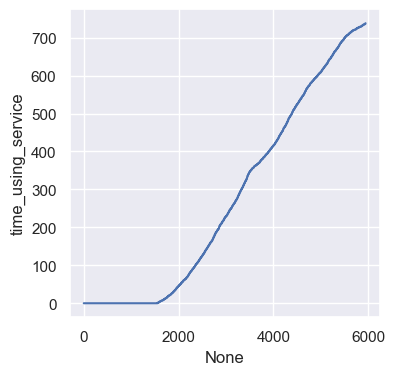

In [11]:
user_times = df.groupby('Customer_ID', as_index=False).agg(min_date = ('InvoiceDate', 'min'),
                              max_date = ('InvoiceDate', 'max'))
user_times['min_date'] = pd.to_datetime(user_times['min_date'])
user_times['max_date'] = pd.to_datetime(user_times['max_date'])
user_times['time_using_service'] = (user_times['max_date'] - user_times['min_date']).dt.days
user_times = user_times.sort_values('time_using_service').reset_index()

plt.figure(figsize=(4,4))
sns.lineplot(x=user_times.index, y=user_times['time_using_service'])

We see a clear plateu of the users that have been on the service for 0 days. Combnined with otherwise linear growth of the time_using_service it seem suscpicoius, seems like other than users that have only joined on the last day of analysis period there are also user that have only used the servies once in the past. Than it is worthy to check, how many of those users had a high refund ratio or other high metric

Also, a large amount of users with time_using_service = 0 can indicate that:
1. certain users are unsatisfied with our service:
    ---> to check it is sensible to analyze the activity of such users. If the have large refund_ratio and strange orders (e.g costistent of one unique item) then they can be the instance of fraudulent activy or users that tried abusing some promo actions of the service. Like creating large orders and cancelling them to get free delivery

    ---> If their behaivour in terms of other features like refind_ratio, purchased items, unique purchased items and cancellation rate is ordinary, that these users seem like those unsatisfied with the service

In [12]:
customers_money_times = customers_money.merge(user_times, how='outer')
customers_money_times.sort_values('refund_ratio', ascending=False).head()

customers_money_times.head()

,index,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
0,0,12346.0,"[ADJUST, M, M, M, M, M, M, M, M, M, M, D, TEST...","[TEST001, TEST001, TEST001, TEST001, TEST002, ...","[20682, 20685, TEST001, 22688, 15056BL, 48187,...",34.0,27.0,77556.46,77621.14,-64.68,1.000834,2009-12-14 08:34:00,2011-01-18 10:17:00,400
1,1,12347.0,[],"[22698, 22699, 20985, 22418, 22422, 51014A, 51...","[23084, 23171, 21976, 20665, 21832, 23172, 234...",253.0,126.0,5633.32,0.00,5633.32,0.000000,2010-10-31 14:20:00,2011-12-07 15:52:00,402
2,2,12348.0,[],"[21213, 84991, 22951, 84992, 21977, 84988, 849...","[21967, 84988, 22952, 84991, 21211, 21725, 217...",51.0,25.0,2019.40,0.00,2019.40,0.000000,2010-09-27 14:59:00,2011-09-25 13:13:00,362
3,3,12349.0,"[22072, 20914, 21231, 21232, 20747]","[22554, 22555, 22553, 16156S, 22052, 22048, 22...","[21533, 22740, 22326, 23253, 22072, 84078A, 23...",175.0,138.0,4428.69,24.15,4404.54,0.005453,2009-12-04 12:49:00,2011-11-21 09:51:00,716
4,4,12350.0,[],"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...","[79066K, 22551, 79191C, 84086C, 22557, 21915, ...",17.0,17.0,334.40,0.00,334.40,0.000000,2011-02-02 16:01:00,2011-02-02 16:01:00,0


In [13]:
#only one user joined on the last day, so that does not make much of a difference
len(customers_money_times['time_using_service']) - len(customers_money_times[pd.to_datetime(customers_money_times['min_date']).dt.date != (pd.to_datetime(customers_money_times['max_date']).dt.date).max()])

1

,index,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
4,4,12350.0,[],"[21908, 22412, 79066K, 79191C, 22348, 84086C, ...","[79066K, 22551, 79191C, 84086C, 22557, 21915, ...",17.0,17.0,334.40,0.00,334.40,0.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0
5,5,12351.0,[],"[22707, 22706, 22045, 22709, 22051, 22050, 218...","[21539, 22709, 20886, 21833, 79000, 84050, 224...",21.0,21.0,300.93,0.00,300.93,0.0,2010-11-29 15:23:00,2010-11-29 15:23:00,0
8,8,12354.0,[],"[23201, 23204, 23205, 23254, 23255, 23256, 219...","[21239, 21242, 21533, 22629, 22839, 22326, 218...",58.0,58.0,1079.40,0.00,1079.40,0.0,2011-04-21 13:11:00,2011-04-21 13:11:00,0
19,19,12365.0,[M],"[22128, 20972, 22585, 21107, 21106, 21358, 213...","[84884A, 22697, 21408, 21974, 21107, 22128, 22...",22.0,22.0,641.38,320.69,320.69,0.5,2011-02-21 13:51:00,2011-02-21 14:04:00,0
20,20,12366.0,[],"[21135, 21136, 84879]","[21136, 84879, 21135]",3.0,3.0,500.24,0.00,500.24,0.0,2010-03-16 10:28:00,2010-03-16 10:28:00,0


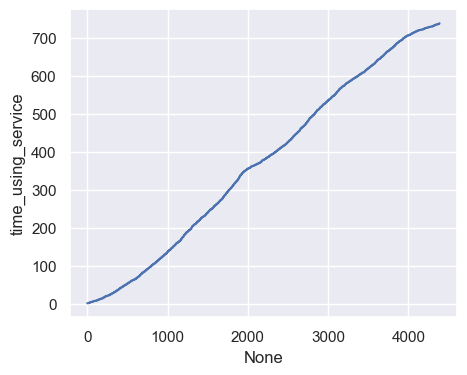

In [14]:
customers_days = customers_money_times[customers_money_times['time_using_service'] > 0]
customers_zero_days = customers_money_times[customers_money_times['time_using_service'] == 0]

Q1days = customers_days['time_using_service'].quantile(0.25)
Q3days = customers_days['time_using_service'].quantile(0.75)
IQRdays = Q3days - Q1days

customers_days = customers_days.sort_values('time_using_service').reset_index().drop(['index','level_0'], axis=1)

plt.figure(figsize=(5,4))
sns.lineplot(x=customers_days.index, y=customers_days['time_using_service'])

customers_zero_days.head()

### Since the dependence is rather linear, we can segment it into three equal piceses

In [15]:
customers_days_new = customers_days[customers_days['time_using_service'] < customers_days['time_using_service'].quantile(0.33)]
customers_days_moderate_time = customers_days[(customers_days['time_using_service'] < customers_days['time_using_service'].quantile(0.66)) & 
                                             (customers_days['time_using_service'] >= customers_days['time_using_service'].quantile(0.33))]
customers_days_long_time = customers_days[customers_days['time_using_service'] >= customers_days['time_using_service'].quantile(0.66)]

customers_days_long_time.head()

,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
2896,14963.0,"[47594B, 47594A]","[48187, 21928, 21937, 21932, 21933, 22382, 475...","[23084, 22326, 15058A, 20970, 21326, 22911, 20...",493.0,304.0,3164.48,5.85,3158.63,0.001849,2010-07-02 12:43:00,2011-11-30 12:16:00,515
2897,15410.0,[],"[21042, 21749, 85099B, 71459, 21216, 21218, 22...","[22926, 21755, 21533, 23171, 23172, 22697, 221...",162.0,80.0,4685.72,0.00,4685.72,0.000000,2010-04-19 08:57:00,2011-09-16 14:47:00,515
2898,15149.0,[],"[22367, 20619, 85066, 48184, 84378, 85098B, 21...","[84378, 85063, 22624, 48184, 22625, 22612, 232...",69.0,62.0,1554.61,0.00,1554.61,0.000000,2010-02-28 11:13:00,2011-07-29 10:58:00,515
2899,15826.0,"[21080, 22784]","[22645, 22644, 20675, 20674, 20677, 20676, 212...","[22740, 21533, 23397, 20674, 22645, 23405, 229...",119.0,100.0,2598.28,15.15,2583.13,0.005831,2010-05-20 17:00:00,2011-10-19 13:24:00,516
2900,15199.0,[],"[21622, 85123A, 21621, 85129C, 85130A, 20997, ...","[22669, 85123A, 22090, 72351B, 20997, 72351A, ...",51.0,17.0,3122.40,0.00,3122.40,0.000000,2010-05-13 10:14:00,2011-10-11 15:12:00,516


1. We have separated our customers into 4 categories
2. Now we need to deal with refund ratio values that exceed 1. The way to explain it is that the user joined with the service before the min_date of the report period, and during the rport period mostly canceled orders
3. We also need to take into account that the dataset description specifies that a lot of customers are wholsalers which explains large orders

In [16]:
customers_zero_days = customers_zero_days.sort_values('refund_ratio').reset_index().drop(['index'],axis=1)
customers_days_new = customers_days_new.sort_values('refund_ratio').reset_index().drop('index',axis=1)
customers_days_moderate_time = customers_days_moderate_time.sort_values('refund_ratio').reset_index().drop('index',axis=1)
customers_days_long_time = customers_days_long_time.sort_values('refund_ratio').reset_index().drop('index',axis=1)

customers_days_long_time.head()

,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
0,15983.0,[],"[35001G, 84429A, 85144, 22112, 79067, 85184C, ...","[20982, 22926, 23348, 21918, 23323, 22619, 215...",316.0,137.0,3958.82,0.0,3958.82,0.0,2009-12-06 12:52:00,2011-11-17 17:34:00,711
1,13305.0,[],"[15030, 82605, 82599, 82600, 82567, 21904, 219...","[22499, 22740, 85130D, 22278, 22072, 17164B, 2...",206.0,153.0,3754.71,0.0,3754.71,0.0,2010-03-10 14:49:00,2011-12-05 15:15:00,635
2,14818.0,[],"[37503, 22053, 84029G, 22088, 21754, 79067, 82...","[21976, 84691, 22528, 21889, 21933, 84029G, 21...",107.0,87.0,1170.41,0.0,1170.41,0.0,2010-03-02 12:48:00,2011-09-27 11:01:00,573
3,17359.0,[],"[84884A, 85107, 22297, 21791, 21361, 21360, 85...","[84884A, 20869, 22411, 72780, 21680, 21361, 22...",38.0,36.0,284.46,0.0,284.46,0.0,2010-03-01 14:48:00,2011-11-28 14:37:00,636
4,18203.0,[],"[90035A, 22241, 21381, 21257, 21735, 85065, 35...","[21377, 21755, 21378, 21380, 22187, 84637, 221...",60.0,40.0,504.42,0.0,504.42,0.0,2009-12-08 13:19:00,2011-07-05 13:07:00,573


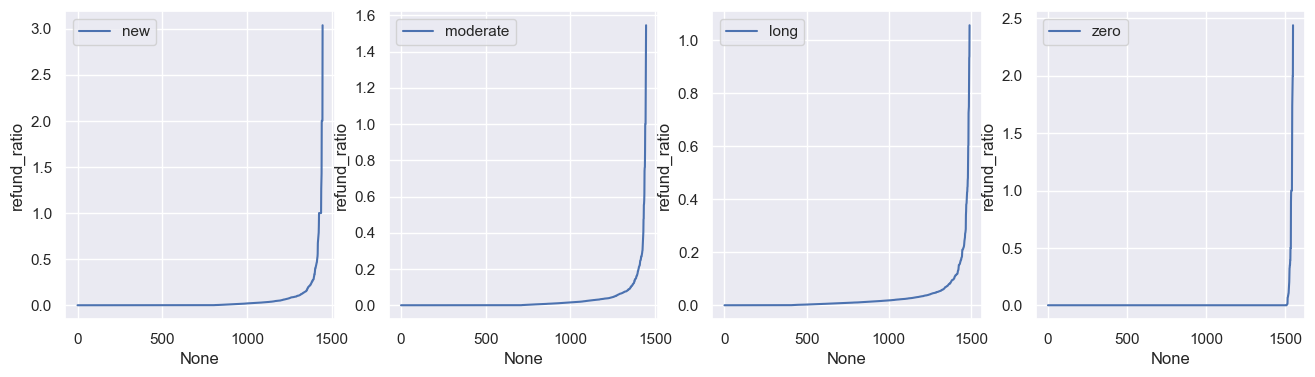

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
sns.lineplot(x=customers_days_new.index, y=customers_days_new['refund_ratio'],ax=axes[0],label='new')
sns.lineplot(x=customers_days_moderate_time.index, y=customers_days_moderate_time['refund_ratio'],ax=axes[1], label='moderate')
sns.lineplot(x=customers_days_long_time.index, y=customers_days_long_time['refund_ratio'],ax=axes[2], label='long')
sns.lineplot(x=customers_zero_days.index, y=customers_zero_days['refund_ratio'],ax=axes[3], label='zero')
plt.show()

In each group we observe similar behaviour, however it is most suspicious for the group tha has 0 days on the service

In [18]:
customers_zero_days[customers_zero_days['refund_ratio'] > 1].head()

,level_0,Customer_ID,Canceled,Purchased,Unique_Purchased,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
1546,3414,15760.0,"[M, M, M]","[M, M]",[M],2.0,1.0,13916.34,19712.21,-5795.87,1.416479,2010-03-19 11:30:00,2010-03-19 11:53:00,0
1547,1962,14308.0,"[M, M, M]","[M, M]",[M],2.0,1.0,1147.02,1996.47,-849.45,1.740571,2010-06-08 16:22:00,2010-06-08 16:52:00,0
1548,2486,14832.0,"[M, M]",[M],[M],1.0,1.0,322.69,597.32,-274.63,1.851064,2010-03-19 13:56:00,2010-03-19 15:15:00,0
1549,2560,14906.0,"[M, M]",[M],[M],1.0,1.0,68.44,135.42,-66.98,1.978667,2010-09-20 15:19:00,2010-09-20 16:33:00,0
1550,3456,15802.0,"[M, M]",[M],[M],1.0,1.0,451.42,902.84,-451.42,2.000000,2011-07-20 11:23:00,2011-07-20 11:40:00,0


We have detected some contradictory data. There are users that have only been on our service for 0 days (meaning that could not have created orders before the start of the analysis preiod). Yet somehow, during the current period that have managed to cancled more orders that they created. Does cancelling also include the possiblity to retrun the orders (the difference being that we include the option to cancel after recieving delivery)? In any case this seems to be a mistake in data collection. Perhaps, some failure in the logs, or it can be a breach in our service and this analysis finds the users that have abused the breach

1. For fruther analysis this users will be removed

In [19]:
customers_to_remove = customers_zero_days[customers_zero_days['refund_ratio'] > 1]['Customer_ID']
customers_to_remove.head()

1546    15760.0
1547    14308.0
1548    14832.0
1549    14906.0
1550    15802.0
Name: Customer_ID, dtype: float64

# 1.1 Zero days users Analysis

In [20]:
customers_zero_days['Purchased'].str.len()

0       17.0
1       32.0
2       13.0
3       11.0
4        5.0
        ... 
1548     1.0
1549     1.0
1550     1.0
1551     1.0
1552     1.0
Name: Purchased, Length: 1553, dtype: float64

In [21]:
customers_zero_days = customers_zero_days[
    ~(customers_zero_days['Canceled'].str.len() > customers_zero_days['Purchased'].str.len())
]
customers_zero_days[customers_zero_days['Canceled'].str.len() == 0]['Customer_ID'].count()/customers_zero_days['Customer_ID'].count()

np.float64(0.9398447606727037)

Among the users that have only used our service once there 93 percent of users that didn't return a single item

In [22]:
customers_money_times.describe()

,index,Customer_ID,Total_Order_Size,Unique_Items,money_recieved,money_back,money_diff,refund_ratio,min_date,max_date,time_using_service
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000,5942,5942,5942.000000
mean,2970.500000,15316.500000,135.580613,81.108549,2986.103867,184.304408,2812.073933,0.032516,2010-08-18 07:44:19.851901440,2011-05-21 02:16:04.069337088,275.396331
min,0.000000,12346.000000,0.000000,0.000000,0.000000,0.000000,-10953.500000,0.000000,2009-12-01 07:45:00,2009-12-01 09:55:00,0.000000
25%,1485.250000,13831.250000,20.000000,18.000000,337.355000,0.000000,325.097500,0.000000,2010-02-03 15:28:30,2010-11-23 14:38:00,0.000000
50%,2970.500000,15316.500000,52.000000,44.000000,875.045000,0.000000,843.970000,0.000000,2010-06-21 10:21:30,2011-09-05 00:30:00,225.000000
75%,4455.750000,16801.750000,141.000000,102.000000,2277.885000,32.530000,2182.005000,0.016042,2011-01-23 02:23:30,2011-11-15 11:08:15,517.000000
max,5941.000000,18287.000000,12890.000000,2550.000000,608821.650000,168478.600000,598215.220000,3.036969,2011-12-09 12:16:00,2011-12-09 12:50:00,738.000000
std,1715.451981,1715.451981,352.228902,116.169710,14661.446161,2698.074290,13967.400357,0.140087,NaN,NaN,259.688017


<Axes: xlabel='money_recieved', ylabel='time_away_days'>

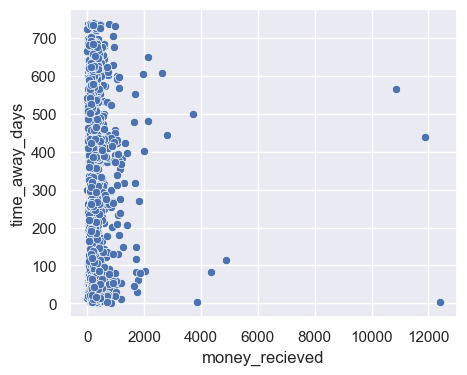

In [23]:
customers_zero_days_no_return_items = customers_zero_days[customers_zero_days['Canceled'].str.len() == 0]
today_date = dt.datetime(2011,12,11)


customers_zero_days_no_return_items['time_away'] = today_date - customers_zero_days_no_return_items['max_date']
customers_zero_days_no_return_items['time_away_days'] = customers_zero_days_no_return_items['time_away'].dt.days
customers_zero_days_no_return_items[['money_recieved','time_away']].head()

plt.figure(figsize=(5,4))
sns.scatterplot(x=customers_zero_days_no_return_items['money_recieved'],y=customers_zero_days_no_return_items['time_away_days'])

We plot the money recieved from the users against the time they have been away. We see that the majority of the people did not contribute a large income to our serivce and have been aways for a substential amount of time

We look at the time_away distribution

<Axes: >

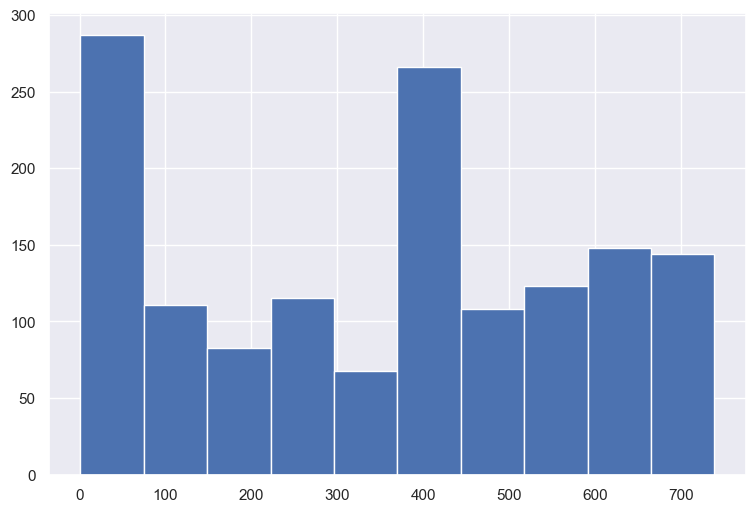

In [24]:
customers_zero_days_no_return_items['time_away_days'].hist()

There is no noticebale skew or some other unsual behaviour in the time_away_days distribution. The users here can include both 
1. those who have ordered something and are satisfied with the service but how not yet returned
2. the unsatisifed users that will not return

However, it is not yet clear how to separate this two groups. We need to determine a threshold for the time_away feature to determine the user as dropped

Let's calculate the time interval in between purchases for each users. Here we will only account for purchases without order cancellation. Because we interested in the time in between purchases for a user. We are not so interested in how much time it takes a user to cancel the order if the order is eventaully canceled

In [27]:
df_time_intervals = df_without_canceled[['Customer_ID','InvoiceDate']]
df_time_intervals = df_time_intervals.sort_values('InvoiceDate')
df_time_intervals['InvoiceDate'] = pd.to_datetime(df_time_intervals['InvoiceDate']).astype('int64')

df_time_intervals.groupby('Customer_ID')['InvoiceDate'].apply(list)

Customer_ID
12346.0    [1260779640000000000, 1260788400000000000, 126...
12347.0    [1288534800000000000, 1288534800000000000, 128...
12348.0    [1285599540000000000, 1285599540000000000, 128...
12349.0    [1272547200000000000, 1272547200000000000, 127...
12350.0    [1296662460000000000, 1296662460000000000, 129...
                                 ...                        
18283.0    [1266599760000000000, 1266599760000000000, 126...
18284.0    [1286191980000000000, 1286191980000000000, 128...
18285.0    [1266402240000000000, 1266402240000000000, 126...
18286.0    [1260960300000000000, 1260960300000000000, 126...
18287.0    [1274097300000000000, 1274097300000000000, 127...
Name: InvoiceDate, Length: 5881, dtype: object

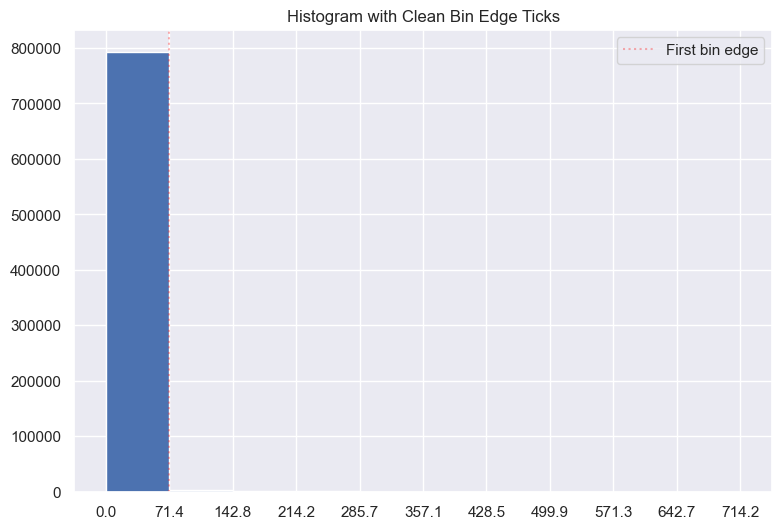

In [35]:
df_time_intervals = df_without_canceled[['Customer_ID','InvoiceDate']]
df_time_intervals = df_time_intervals.sort_values('InvoiceDate')
df_time_intervals['InvoiceDate'] = pd.to_datetime(df_time_intervals['InvoiceDate']).astype('int64')
gap_data = df_time_intervals.groupby('Customer_ID')['InvoiceDate'].apply(list).apply(np.diff).values

gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data = gap_data / (1e9 * 60 * 60 * 24) #diff in days


counts, bin_edges = np.histogram(gap_data)

# Plot histogram
plt.hist(gap_data, bins=bin_edges)

# Set ticks ONLY at bin edges (no extra ticks)
plt.xticks(bin_edges)

# Highlight the first bin's right edge (optional)
plt.axvline(x=bin_edges[1], color='red', linestyle=':', alpha=0.3, label='First bin edge')
plt.legend()

plt.title("Histogram with Clean Bin Edge Ticks")
plt.show()

From this histogram we see that after placing an order almost all the users that create an order in the future do that within the next 72 days. Therefore we can use this value as a threshold

This way we obtai the insight that the majority of the users with time_using_service = 0 are actulally ordinary users that created an orders and did not return to our serivce

# Results

1. We have detected that there is strange behaviour in the dataset, users cancel and return more orders that they have ever created. Seems like a breach in the data set
2. We have identified a significant number of users with zero days of service usage. Among these users, 93% did not return any orders. By analyzing the distribution of time intervals between orders, we conclude that users with zero days of activity are those who have discontinued using our service.

This can be an indication that the order from our service satisifed the users and they did not have to return, yet the have found a service with a better offer. From the description that a lot of users a big wholesalers we can assume that our service provides better terms for wholsalers rather than for ordinary users

3. We have found that the users can be segmented into 4 categories:
    1. Zero days on service
    2. New users
    2. Moderate time users
    3. Long time users
4. In each segment we find users with refund ratio > 1. This indicates that there are suers that have created orders in the prevoius report period and during the current report period they canceled more (including their past orders) that they ordered

# 2. Recency, Frequency and Monetary Value --- RFM Analysis

1. Create a table of receny, frequency and monetary by users, considerring only the non canceled orders

In [20]:
today_date = dt.datetime(2011,12,11)
#drop users described above

df_without_canceled[~df_without_canceled['Customer_ID'].isin(customers_to_remove)]

data_rfm = df_without_canceled.groupby('Customer_ID').agg({'InvoiceDate':'max', 'Invoice':'nunique','money_recieved':'sum'})
data_rfm = data_rfm.rename(columns={'InvoiceDate':'Recency','Invoice':'Frequency', 'money_recieved':'Monetary'})
data_rfm['Recency'] = (today_date - pd.to_datetime(data_rfm['Recency'])).dt.days

data_rfm.sort_values('Monetary', ascending=False)

df_without_canceled['Customer_ID'].nunique()

data_rfm

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40
...,...,...,...
18283.0,4,22,2736.65
18284.0,432,1,461.68
18285.0,661,1,427.00


2. Classify the users by their Recency, Frequecny and Monetary

## 2.1 Theory (Classification aalysis, Optimal n_clusters)

1. Elbow Method:

For each cluster $C_i$ with centroids $\mu_i$, the Within-Cluster-Sum-of-Squares (WCSS)
$$\text{WCSS} = \sum\limits_{i = 1}^{k}\sum\limits_{x \in C_i}||x - \mu_i||^2$$
The elbow method looks for a point where an abrupt drop in the WCSS accurs. With further increase of $k$ the WCSS keeps decreasing (however the model becomes overfitted), therefore we look for an 'elbow'-shaped point. In our case (see Elbow Method graph) k = 3 or 4 seems to be a good candidate. Although it is worth checking the exact number of clusters further

2. Silhouette Analysis:

Silhouette score is calculated as
$$s(i) = \frac{b(i) - a(i)}{\text{max}\{a(i),b(i)\}}$$

where $a(i)$ -  Mean intra-cluster distance (average distance from point $i$ to every other point in the same cluster), $b(i)$ - Mean nearest-cluster distance (the average distance from point $i$ to all points in the neighbouring nearest cluster)

$$a(i) = \frac{1}{|C_i| - 1}\sum\limits_{j\in C, j \ne i}\text{dist}(i,j)$$
$$b(i) = \min_{C' \ne C}\left(\frac{1}{|C'|}\sum\limits_{j\in C'}\text{dist}(i,j)\right)$$
$|C|$ is the number of points in cluster $C$

3. Calinski-Harabasz Index:

$$B_k = \sum\limits_{i = 1}^{k}n_i(\bold{c}_i - \bold{c})(\bold{c}_i - \bold{c})^T$$
$n_i$ is the number of points in cluster $C_i$, $\bold{c}_i$ is the centroid of cluster $C_i$, $\bold{c}$ is the centroid of the entire dataset. $B_k$ reflects the spread between clusters

$$W_k = \sum\limits_{i = 1}^{k}\sum\limits_{x \in C_i}(\bold{x}_i - \bold{c}_i)(\bold{x}_i - \bold{c}_i)^T$$
$W_k$ measures how dispersed the points are around thier respective centroids $\bold{c}_i$. The index:

$$\text{CH} = \frac{\text{trace}(B_k)}{\text{trace}(W_k)} \frac{n-k}{k-1}$$
Hihger value of the index means better clustering. Of the index keeps increasing with the increase in $k$ it might suggest that the model is overfitting

4. Davies-Bouldin Index

$$S_i = \frac{1}{n_i}\sum\limits_{i = 1}^{k}\sum\limits_{x \in C_i}||x - \mu_i||$$
$S_i$ measures how compact the cluster is. Inter-cluster separation matrix
$$M_{ij} = ||\mu_i - \mu_j||$$
Cluster Similarity Score
$$R_{ij} = \frac{S_i + S_j}{M_{ij}}$$
Worst case similarity for each cluster
$$R_i = \max_{j \ne i}R_{ij}$$
The index is the average of the worst case similarities
$$\text{DBI} = \frac{1}{k}\sum\limits_{i = 1}^{k}R_i$$

The lower values of the DBI indicate better clustering

## 2.2 Kmeans Clustering

For n_clusters = 2, silhouette score is 0.916
For n_clusters = 3, silhouette score is 0.580
For n_clusters = 4, silhouette score is 0.591
For n_clusters = 5, silhouette score is 0.603
For n_clusters = 6, silhouette score is 0.551
For n_clusters = 7, silhouette score is 0.549
For n_clusters = 8, silhouette score is 0.542
For n_clusters = 9, silhouette score is 0.536
For n_clusters = 10, silhouette score is 0.502


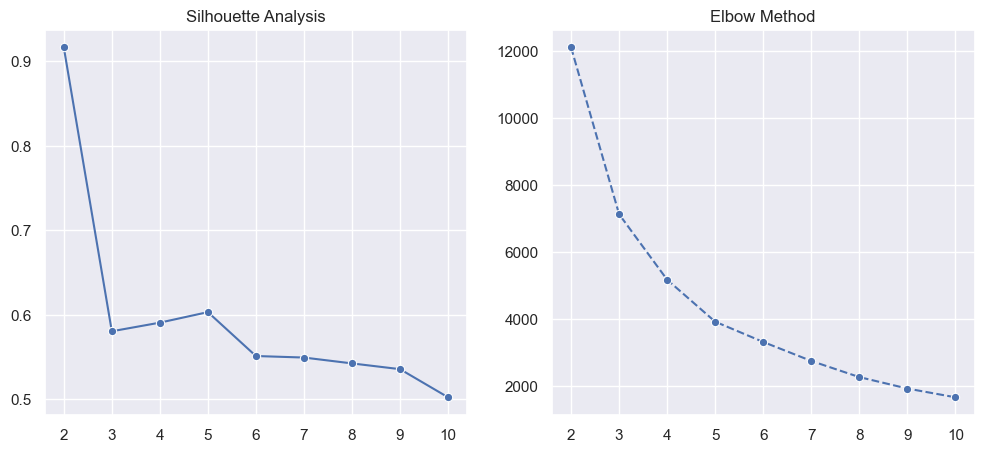

In [21]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_rfm)

max_clusters = 10
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = range(2, max_clusters+1)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, silhouette score is {silhouette_avg:.3f}")

wcss = []
max_clusters = 10  # Set based on your domain knowledge

for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(x=range_n_clusters, y=silhouette_scores, marker='o', ax=ax1)
ax1.set_title('Silhouette Analysis')
ax1.set_xticks(range(2, max_clusters+1))

sns.lineplot(x=range(2, max_clusters+1), y=wcss, marker='o', linestyle='--', ax=ax2)
ax2.set_title('Elbow Method')
ax2.set_xticks(range(2, max_clusters+1))

plt.show()


1. Silhouette Analysis ---> k = 2
2. Elbow Method ---> k = 3 or 4

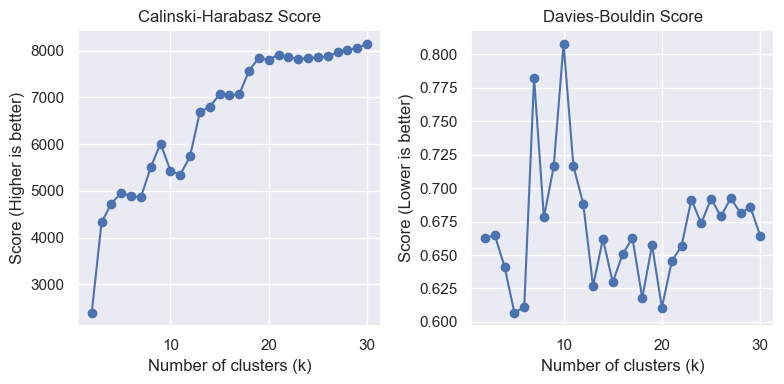

In [22]:
k_values = range(2, 31)
ch_scores = []
db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)  # Use scaled data
    
    ch = calinski_harabasz_score(scaled_data, labels)
    ch_scores.append(ch)
    
    db = davies_bouldin_score(scaled_data, labels)
    db_scores.append(db)


plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(k_values, ch_scores, marker='o')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score (Higher is better)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, db_scores, marker='o')
plt.title('Davies-Bouldin Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score (Lower is better)')
plt.grid(True)

plt.tight_layout()
plt.show()

1. Calinski-Harabasz Score ---> k >20 (Overfitting???)
2. Davies-Bouldin Score ---> k = 5,6 maybe 20?

To further analyse the performance of the Kmeans classifier we calculate Adjusted Rand Index. In the absence of ground truth, ARI can be used to assess how consistent the clustering results are across multiple runs with different random seeds or initializations.

In [23]:
from sklearn.metrics import adjusted_rand_score
import random

def cluster_stability(X, k, n_runs=100):
    clusterings = []
    
    for i in range(n_runs):
        kmeans = KMeans(n_clusters=k, random_state=random.randint(0, 200))
        labels = kmeans.fit_predict(X)
        clusterings.append(labels)
    
    # Compute ARI between all pairs of clusterings
    n = len(clusterings)
    ari_scores = []
    for i in range(n):
        for j in range(i+1, n):
            score = adjusted_rand_score(clusterings[i], clusterings[j])
            ari_scores.append(score)
    
    mean_ari = np.mean(ari_scores)
    print(f"Mean ARI over {n_runs} runs for k={k}: {mean_ari:.3f}")
    return mean_ari

# Usage
stability_score = cluster_stability(scaled_data, k=2)
stability_score = cluster_stability(scaled_data, k=3)
stability_score = cluster_stability(scaled_data, k=4)
stability_score = cluster_stability(scaled_data, k=5)
stability_score = cluster_stability(scaled_data, k=6)
stability_score = cluster_stability(scaled_data, k=20)



Mean ARI over 100 runs for k=2: 0.487
Mean ARI over 100 runs for k=3: 0.872
Mean ARI over 100 runs for k=4: 0.900
Mean ARI over 100 runs for k=5: 0.775
Mean ARI over 100 runs for k=6: 0.804
Mean ARI over 100 runs for k=20: 0.764


In [24]:
print(silhouette_scores[1], db_scores[1])

0.5803392830229628 0.6649016842022718


### Result for Kmeans: the best classifiers is with n_cluster = 3. The scores Are
1. Silhouette Score = 0.58
2. Davies-Bouldin Score = 0.66
3. ARI = 0.9

# 2.3 Analyse applicability of Kmeans

1. Plot the data points in the PCA coordinates, see if it exhibits blob like structure with spherically shaped equally populated clusters

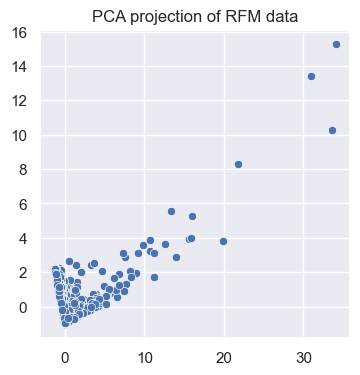

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assume X_scaled is your scaled RFM data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(4,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title("PCA projection of RFM data")
plt.show()

Seems like the data distribution is not suitable for Kmeans

1. Run log transform on the data --- it reduces its skew (decreases the impact of the outliers)
2. We can apply the PCA on the transformed data

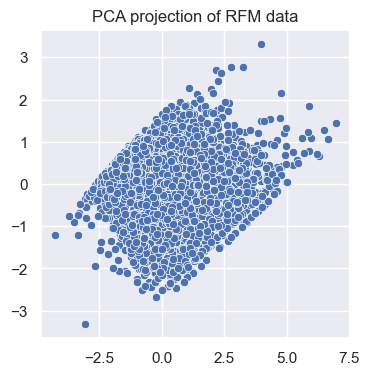

In [26]:
data_rfm_log = np.log1p(data_rfm)  

scaled_data_log = scaler.fit_transform(data_rfm_log)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data_log)

plt.figure(figsize=(4,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title("PCA projection of RFM data")
plt.show()


Text(0.5, 1.0, 'Monetary')

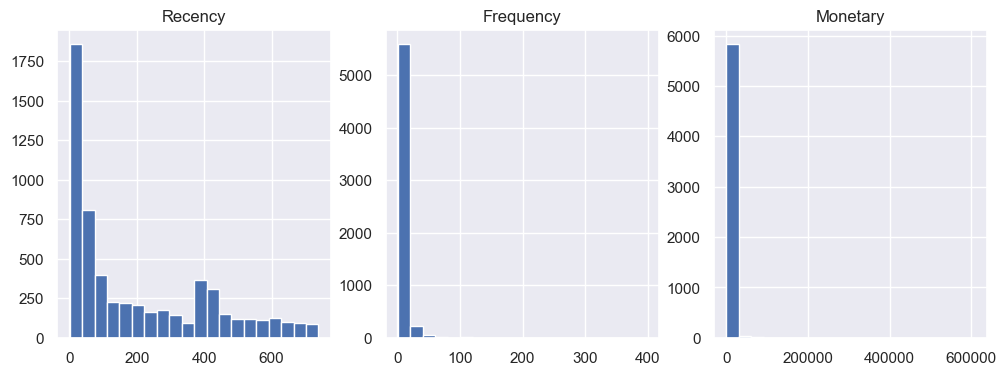

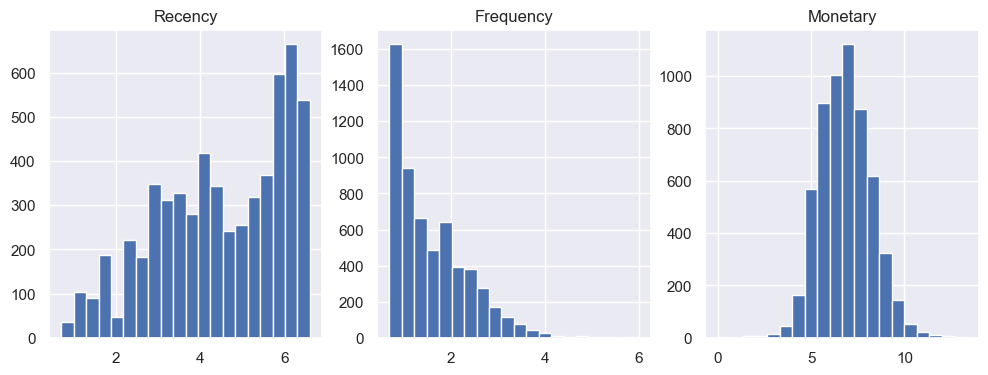

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
data_rfm['Recency'].hist(ax=axes[0], bins=20).set_title('Recency')
data_rfm['Frequency'].hist(ax=axes[1],bins=20).set_title('Frequency')
data_rfm['Monetary'].hist(ax=axes[2],bins=20).set_title('Monetary')

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
np.log1p(data_rfm['Recency']).hist(ax=axes[0], bins=20).set_title('Recency')
np.log1p(data_rfm['Frequency']).hist(ax=axes[1], bins=20).set_title('Frequency')
np.log1p(data_rfm['Monetary']).hist(ax=axes[2], bins=20).set_title('Monetary')

In [28]:
data_rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


# 2.4 Hopkins test to analyse clusterability of the dataset

In [29]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np

X_raw = data_rfm[['Recency', 'Frequency', 'Monetary']]

X_raw_scaled = StandardScaler().fit_transform(X_raw)

def hopkins_statistic(X, sample_ratio=0.1):
    X = StandardScaler().fit_transform(X)
    n = int(X.shape[0] * sample_ratio)
    rand_X = np.random.uniform(X.min(axis=0), X.max(axis=0), (n, X.shape[1]))
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    real_dists, _ = nbrs.kneighbors(X, n_neighbors=2)
    rand_dists, _ = nbrs.kneighbors(rand_X, n_neighbors=1)
    H = np.sum(rand_dists) / (np.sum(real_dists[:,1]) + np.sum(rand_dists))
    return H

# Apply to your scaled data (should be >0.5 to indicate clusterability)
print(f"Hopkins Statistic: {hopkins_statistic(X_raw_scaled):.2f}")

Hopkins Statistic: 0.94


Hopkins Test ---> Raw data is forms more distinct clusters

1. However, it is questionable where it is the actual clusterability of the data that we find or
2. There are a lot of outliers and the test indicates that outliers and regular data can be separated

# 2.4.1 Hopkins test theory:

### 1. Mathematical Foundation

The Hopkins statistic ($H$) is calculated as:
$$H = \frac{\sum_{i=1}^m d(y_i, NNY(y_i))}{\sum_{i=1}^m d(y_i, NNY(y_i)) + \sum_{i=1}^m d(x_i, NNX(x_i))}$$

1. $X$ = Real dataset (scaled)

2. $Y$ = Uniformly random dataset (sampled from the same bounds as $X$)

3. $m$ = Number of sampled points (typically 10\% of the dataset)

4. $d(a,b)$ = Euclidean distance between points $a$ and $b$

5. $NNX(x_i)$ = Nearest neighbor of $x_i$ in the real dataset

6. $NNY(y_i)$ = Nearest neighbor of $y_i$ in the random dataset

### 2 Step-by-Step Calculation

Step 1: Data Preparation
Scale the dataset (e.g., using \texttt{StandardScaler} or \texttt{RobustScaler}):
$$X_{\text{scaled}} = \frac{X - \mu}{\sigma}$$

Step 2: Generate Random Uniform Data
Sample $m$ points from a uniform distribution covering the same range as $X$:
$$Y \sim \text{Uniform}(\min(X), \max(X))$$

Step 3: Compute Distances
For each random point $y_i$ in $Y$, find its nearest neighbor in the $\textbf{real data}$ $X$:
$$d_{\text{random}} = \sum_{i=1}^m \|y_i - NNX(y_i)\|$$
For each real point $x_i$ in $X$, find its nearest neighbor in the $\textbf{real data}$ (excluding itself):
$$d_{\text{real}} = \sum_{i=1}^m \|x_i - NNX(x_i)\|$$

Step 4: Calculate Hopkins Statistic
$$H = \frac{d_{\text{random}}}{d_{\text{random}} + d_{\text{real}}}$$

### 3. Isolation forest to check if the outliers are driving the Hopkins test




In [30]:
Q3R = data_rfm['Recency'].quantile(0.75)
Q1R = data_rfm['Recency'].quantile(0.25)
IQRR = Q3R-Q1R
Q3F = data_rfm['Frequency'].quantile(0.75)
Q1F = data_rfm['Frequency'].quantile(0.25)
IQRF = Q3F-Q1F

Q3M = data_rfm['Monetary'].quantile(0.75)
Q1M = data_rfm['Monetary'].quantile(0.25)
IQRM = Q3M-Q1M
features = ['Recency', 'Frequency', 'Monetary']
quantiles = [[Q1R, Q3R, IQRR], [Q1F, Q3F, IQRF], [Q1M, Q3M, IQRM]]
for i in range(3):
    feature = features[i]
    Q1,Q3,IQR = quantiles[i]
    print(f"Anomaly proportion in {features[i]}: {data_rfm[(data_rfm[feature] > Q3 + 1.5*IQR) | (data_rfm[feature] < Q1 - 1.5*IQR)][feature].count()/data_rfm[feature].count():.2f}")


from sklearn.ensemble import IsolationForest

# Detect outliers
iso = IsolationForest(contamination=0.18).fit(X_raw)
outlier_mask = iso.predict(X_raw) == -1

print('-------------------------')
X_clean = X_raw[~outlier_mask]
print(f"Hopkins without outliers: {hopkins_statistic(X_clean):.2f}")

Anomaly proportion in Recency: 0.00
Anomaly proportion in Frequency: 0.07
Anomaly proportion in Monetary: 0.11
-------------------------
Hopkins without outliers: 0.72


Hopkins test indicates clusterability, however it is insightful to run Hopkins test on the dataset transformed to PCA components

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_rfm)
pca = PCA(n_components=3)  
principal_components = pca.fit_transform(X_scaled)

pca_features = pca.fit_transform(X_scaled)
pc_columns = [f'PC_{i+1}' for i in range(pca_features.shape[1])]
pca_df = pd.DataFrame(data=pca_features, columns=pc_columns)

pca_df.head()

,PC_1,PC_2,PC_3
0,3.356510,2.420082,-3.002950
1,0.536006,-0.796149,-0.173658
2,0.099303,-0.593212,-0.119945
3,0.247736,-0.796283,-0.328331
4,-0.575378,0.360732,-0.088805


In [32]:
print(f"Hopkins Statistic: {hopkins_statistic(pca_df):.2f}")
iso = IsolationForest(contamination=0.18).fit(pca_df)
outlier_mask = iso.predict(pca_df) == -1
X_clean = pca_df[~outlier_mask]
print(f"Hopkins without outliers: {hopkins_statistic(X_clean):.2f}")

Hopkins Statistic: 0.95
Hopkins without outliers: 0.69


In [33]:
pca_df

,PC_1,PC_2,PC_3
0,3.356510,2.420082,-3.002950
1,0.536006,-0.796149,-0.173658
2,0.099303,-0.593212,-0.119945
3,0.247736,-0.796283,-0.328331
4,-0.575378,0.360732,-0.088805
...,...,...,...
5876,1.138277,-0.717428,0.735967
5877,-0.771673,0.897428,-0.004119
5878,-1.155245,1.906452,0.168771
5879,-0.757981,1.126534,0.046775


Hopkins Statistic result stays relatively the same. We see that a lot of clusterability is driven by the presence of outliers. This suggests the data can be split into regular and outliers. However, after removing the outliers the data still exhibits good potential to be clusterized

Now let us also remove the outliers based on the percentiles and run the Hopkins test yet again

In [34]:
def remove_outliers(data_rfm,features):
    for col in features:
        upper = np.percentile(data_rfm[col], 95)
        lower = np.percentile(data_rfm[col], 5)
        data_rfm = data_rfm[(data_rfm[col] >= lower) & (data_rfm[col] <= upper)]
    return data_rfm

data_rfm_reg = data_rfm.copy()
features = data_rfm_reg.columns
data_rfm_reg = remove_outliers(data_rfm_reg,features)
correlation_matrix = data_rfm_reg.corr()

scaler = StandardScaler()
X_scaled_1 = scaler.fit_transform(data_rfm_reg)

pca_1 = PCA(n_components=3)
X_pca_1 = pca.fit_transform(X_scaled_1)

pca_df_1 = pd.DataFrame(X_pca_1, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df_1.corr()

,PCA1,PCA2,PCA3
PCA1,1.000000e+00,3.047254e-18,-1.020492e-15
PCA2,3.047254e-18,1.000000e+00,-7.562892e-16
PCA3,-1.020492e-15,-7.562892e-16,1.000000e+00


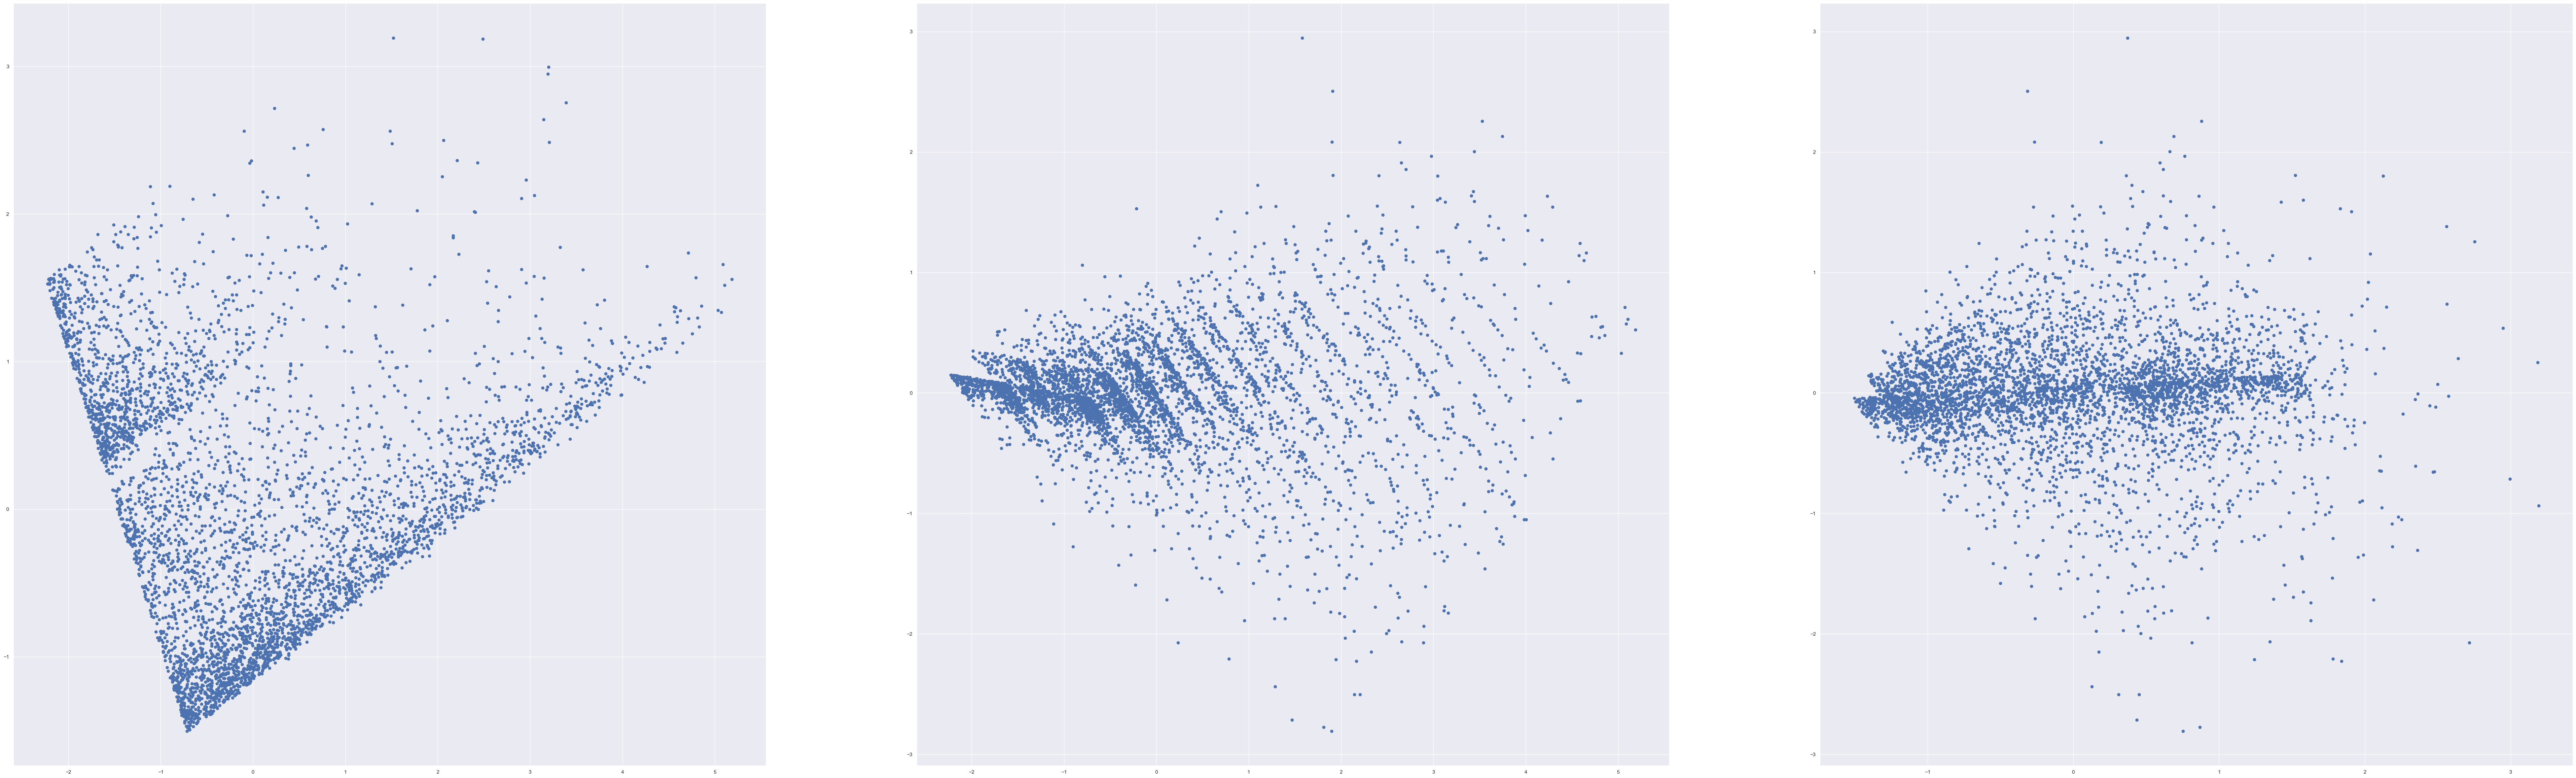

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(100, 30))
axes[0].scatter(x=pca_df_1['PCA1'],y=pca_df_1['PCA2'])
axes[1].scatter(x=pca_df_1['PCA1'],y=pca_df_1['PCA3'])
axes[2].scatter(x=pca_df_1['PCA2'],y=pca_df_1['PCA3'])

In [36]:
print(f"Hopkins Statistic: {hopkins_statistic(pca_df_1):.2f}")
iso = IsolationForest(contamination=0.18).fit(pca_df_1)
outlier_mask = iso.predict(pca_df_1) == -1
X_clean_1 = pca_df_1[~outlier_mask]
print(f"Hopkins without outliers: {hopkins_statistic(X_clean_1):.2f}")

Hopkins Statistic: 0.54
Hopkins without outliers: 0.42


Outlier removal based on the percentiles seems to be more strict, and the Hopkins test now suggest poor clusterability

# 3. More Complex Clusterization --- DBSCAN

In [37]:
data_rfm

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40
...,...,...,...
18283.0,4,22,2736.65
18284.0,432,1,461.68
18285.0,661,1,427.00


In [38]:
from sklearn.cluster import DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_rfm)

dbscan = DBSCAN(eps=0.1, min_samples=50)
labels = dbscan.fit_predict(X_scaled)

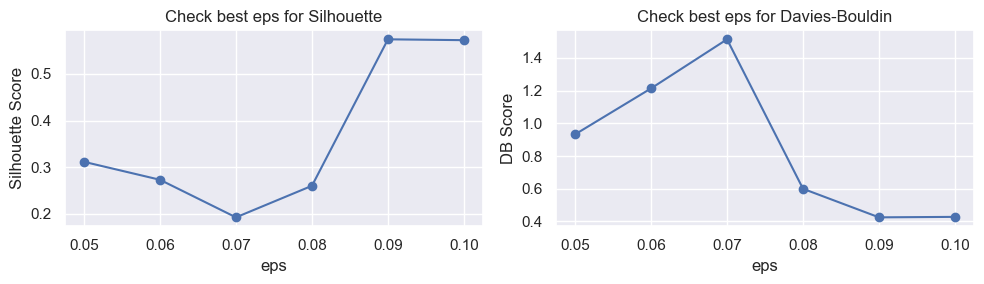

In [39]:
eps_s = [0.05,0.06,0.07,0.08,0.09,0.1]
min_samples_value = 50  # You fixed min_samples in this loop
sil_scores = []
db_scores = []

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for eps_i in eps_s:
    dbscan = DBSCAN(eps=eps_i, min_samples=50)
    labels = dbscan.fit_predict(X_scaled)

    core_samples_mask = labels != -1
    X_core = X_scaled[core_samples_mask]
    labels_core = labels[core_samples_mask]

    n_clusters = len(set(labels_core))

    if len(X_core) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X_core, labels_core)
        db_score = davies_bouldin_score(X_core, labels_core)
        sil_scores.append(silhouette)
        db_scores.append(db_score)
    else:
        sil_scores.append(np.nan)
        db_scores.append(np.nan)
        print(f"eps={eps_i}: Not enough clusters to compute scores.")

# Plotting
axes[0].plot(eps_s, sil_scores, marker='o')
axes[0].set_title('Check best eps for Silhouette')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')

axes[1].plot(eps_s, db_scores, marker='o')
axes[1].set_title('Check best eps for Davies-Bouldin')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('DB Score')

plt.tight_layout()
plt.show()


min_samp=15, : Not enough clusters to compute scores.
min_samp=30, : Not enough clusters to compute scores.
min_samp=250, : Not enough clusters to compute scores.
min_samp=300, : Not enough clusters to compute scores.
min_samp=350, : Not enough clusters to compute scores.
min_samp=400, : Not enough clusters to compute scores.
min_samp=450, : Not enough clusters to compute scores.
min_samp=500, : Not enough clusters to compute scores.


Text(0.5, 1.0, 'check the best min_samp for db')

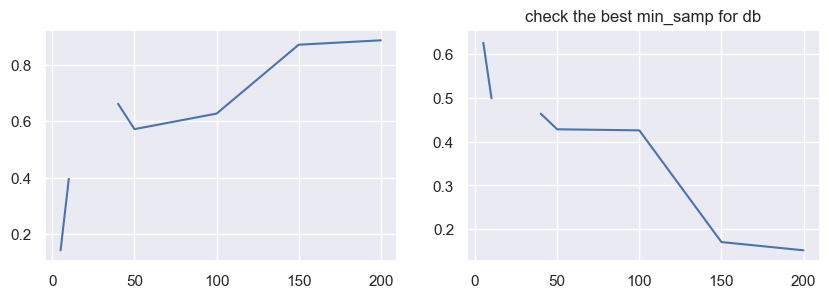

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sil_scores = []
db_scores = []
min_samp = [5,10,15,20,30,40,50,100,150,200,250,300,350,400,450,500]
for ms in min_samp:
    dbscan = DBSCAN(eps=0.1, min_samples=ms)
    labels = dbscan.fit_predict(X_scaled)

    core_samples_mask = labels != -1
    X_core = X_scaled[core_samples_mask]
    labels_core = labels[core_samples_mask]

    n_clusters = len(set(labels_core))

    if len(X_core) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X_core, labels_core)
        db_score = davies_bouldin_score(X_core, labels_core)
        sil_scores.append(silhouette)
        db_scores.append(db_score)
    else:
        sil_scores.append(np.nan)
        db_scores.append(np.nan)
        print(f"min_samp={ms}, : Not enough clusters to compute scores.")

axes[0].plot(min_samp, sil_scores)
plt.title('check the best min_samp for sil')
axes[1].plot(min_samp, db_scores)
plt.title('check the best min_samp for db')

### Result for DBSCAN: performs best for eps = 0.1, min_sample = 200

# 4. Add cluster values to RFM Dataset

In [41]:
kmeans = KMeans(n_clusters=3, random_state=random.randint(0, 200))
dbscan = DBSCAN(eps=0.1, min_samples=200)
scaled_data=scaler.fit_transform(data_rfm)
cluster_labels_K = kmeans.fit_predict(scaled_data)
cluster_labels_D = dbscan.fit_predict(scaled_data)

data_rfm_clusters = data_rfm.copy()
cluster_labels_K = kmeans.fit_predict(scaled_data)
cluster_labels_D = dbscan.fit_predict(scaled_data)

# Create new dataframe with cluster labels
agr = []

data_rfm_clusters['cluster_K'] = cluster_labels_K  # Use the labels we just computed
data_rfm_clusters['cluster_DB'] = cluster_labels_D + 1
data_rfm_clusters['Agreement'] = (data_rfm_clusters['cluster_K'] == data_rfm_clusters['cluster_DB'])
data_rfm_clusters['K_DB'] = data_rfm_clusters['cluster_K'].apply(lambda x: str(x)) + data_rfm_clusters['cluster_DB'].apply(lambda x: str(x))



data_rfm_clusters.head()

,Recency,Frequency,Monetary,cluster_K,cluster_DB,Agreement,K_DB
Customer_ID,,,,,,,
12346.0,326,12,77556.46,1,0,False,10
12347.0,3,8,5633.32,1,0,False,10
12348.0,76,5,2019.40,1,0,False,10
12349.0,19,4,4428.69,1,0,False,10
12350.0,311,1,334.40,0,0,True,00


In [42]:
data_rfm_clusters['K_DB'].nunique()

5

Recency        Frequency          Monetary           
             mean median      mean median       mean     median
cluster_K                                                      
0          462.83  431.0      2.20    1.0     763.47     381.09
1           66.91   41.0      7.64    5.0    3201.39    1362.20
2           23.55    3.0    143.14  135.0  176557.66  130013.83

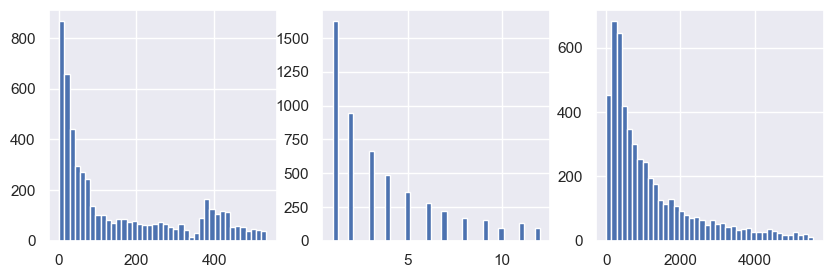

In [43]:
cluster_summary_K = data_rfm_clusters.groupby('cluster_K').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)
cluster_summary_DB = data_rfm_clusters.groupby('cluster_DB').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)
cluster_summary_K_DB = data_rfm_clusters.groupby('K_DB').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
data_rfm[data_rfm['Recency'] < data_rfm['Recency'].quantile(0.90)]['Recency'].hist(bins=40,ax=axes[0])
data_rfm[data_rfm['Frequency'] < data_rfm['Frequency'].quantile(0.90)]['Frequency'].hist(bins=40,ax=axes[1])
data_rfm[data_rfm['Monetary'] < data_rfm['Monetary'].quantile(0.90)]['Monetary'].hist(bins=40,ax=axes[2])
cluster_summary_K.head()

In [44]:
cluster_summary_DB.head()

Recency        Frequency        Monetary         
              mean median      mean median     mean   median
cluster_DB                                                  
0           233.70  163.0      8.27    5.0  4187.58  1380.73
1            35.22   30.0      2.73    2.0   809.07   689.53
2           402.69  401.0      1.52    1.0   463.34   357.48

In [45]:
cluster_summary_K_DB.head()

Recency        Frequency          Monetary           
        mean median      mean median       mean     median
K_DB                                                      
00    486.18  492.0      2.47    1.0     880.04     389.26
02    402.69  401.0      1.52    1.0     463.34     357.48
10     85.38   61.0     10.50    8.0    4596.25    2573.69
11     35.22   30.0      2.73    2.0     809.07     689.53
20     23.55    3.0    143.14  135.0  176557.66  130013.83

# 5. Bin Labeling for RFM Analysis

Clusterization may not always be the most correct and efficient way to segemnt the customers. For buisness purposes it may be more insightful to label each feature to some bin number based on the quantile separation

In [46]:
data_rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40


In [47]:
data_rfm_clusters['RecencyScore'] = pd.qcut(data_rfm_clusters["Recency"], 5, labels = [5, 4 , 3, 2, 1])
data_rfm_clusters['FrequencyScore']= pd.qcut(data_rfm_clusters["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
data_rfm_clusters['MonetaryScore'] = pd.qcut(data_rfm_clusters['Monetary'], 5, labels = [1, 2, 3, 4, 5])

data_rfm_clusters['Score'] = data_rfm_clusters['RecencyScore'].astype(str) + data_rfm_clusters['FrequencyScore'].astype(str) + data_rfm_clusters['MonetaryScore'].astype(str)

data_rfm_clusters.head()


,Recency,Frequency,Monetary,cluster_K,cluster_DB,Agreement,K_DB,RecencyScore,FrequencyScore,MonetaryScore,Score
Customer_ID,,,,,,,,,,,
12346.0,326,12,77556.46,1,0,False,10,2,5,5,255
12347.0,3,8,5633.32,1,0,False,10,5,4,5,545
12348.0,76,5,2019.40,1,0,False,10,3,4,4,344
12349.0,19,4,4428.69,1,0,False,10,5,3,5,535
12350.0,311,1,334.40,0,0,True,00,2,1,2,212


Segmentation map is based on the buisness interpratation. The number of labels and the later assginment can be different. We will compare this result with the clusterization

In [48]:
def assign_rfm_segment(row):
    r, f, m = row['RecencyScore'], row['FrequencyScore'], row['MonetaryScore']
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif r >= 4 and f >= 3 and m >= 3:
        return "Loyal Customers"
    elif r >= 3 and f >= 3 and m <= 3:
        return "Potential Loyalists"
    elif r >= 4 and f <= 2 and m <= 2:
        return "Recent Customers"
    elif r <= 3 and f <= 3 and m <= 3:
        return "At-Risk"
    elif r <= 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    elif r <= 2 and f <= 2 and m <= 2:
        return "Hibernating"
    else:
        return "Lost"
    

data_rfm_clusters['RFM_Segment'] = data_rfm_clusters.apply(assign_rfm_segment, axis=1)
data_rfm_clusters

,Recency,Frequency,Monetary,cluster_K,cluster_DB,Agreement,K_DB,RecencyScore,FrequencyScore,MonetaryScore,Score,RFM_Segment
Customer_ID,,,,,,,,,,,,
12346.0,326,12,77556.46,1,0,False,10,2,5,5,255,Can't Lose Them
12347.0,3,8,5633.32,1,0,False,10,5,4,5,545,Champions
12348.0,76,5,2019.40,1,0,False,10,3,4,4,344,Lost
12349.0,19,4,4428.69,1,0,False,10,5,3,5,535,Loyal Customers
12350.0,311,1,334.40,0,0,True,00,2,1,2,212,At-Risk
...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,4,22,2736.65,1,0,False,10,5,5,4,554,Champions
18284.0,432,1,461.68,0,2,False,02,1,2,2,122,At-Risk
18285.0,661,1,427.00,0,0,True,00,1,2,2,122,At-Risk


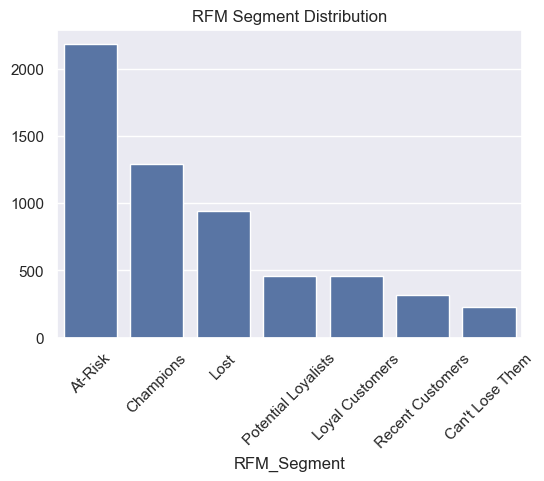

In [49]:
segment_counts = data_rfm_clusters['RFM_Segment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.xticks(rotation=45)
plt.title("RFM Segment Distribution")
plt.show()

In [50]:
cluster_summary_RFM = data_rfm_clusters.groupby('RFM_Segment', as_index=False).agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)

cluster_summary_RFM

RFM_Segment Recency        Frequency        Monetary         
                          mean median      mean median     mean   median
0              At-Risk  392.42  398.0      1.53    1.0   395.85   321.77
1      Can't Lose Them  340.89  326.5      8.91    7.0  4478.21  2262.64
2            Champions   20.27   17.0     17.12   11.0  9354.32  4030.80
3                 Lost  178.89  115.0      5.80    4.0  2953.13  1828.44
4      Loyal Customers   24.74   22.0      4.05    4.0  1273.84  1013.52
5  Potential Loyalists   85.19   74.0      3.70    3.0   631.57   563.42
6     Recent Customers   28.71   27.0      1.33    1.0   294.17   276.56

([<matplotlib.axis.XTick at 0x2b02f7830>,
 [Text(1.33, 0, '1.33'),
  Text(2.9090000000000003, 0, '2.91'),
  Text(4.488, 0, '4.49'),
  Text(6.067, 0, '6.07'),
  Text(7.646000000000001, 0, '7.65'),
  Text(9.225000000000001, 0, '9.23'),
  Text(10.804, 0, '10.80'),
  Text(12.383000000000001, 0, '12.38'),
  Text(13.962000000000002, 0, '13.96'),
  Text(15.541000000000002, 0, '15.54'),
  Text(17.12, 0, '17.12')])

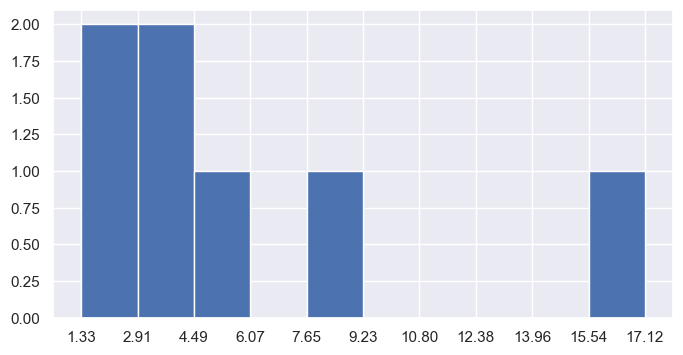

In [51]:
counts, bin_edges = np.histogram(cluster_summary_RFM['Frequency']['mean']) 

plt.figure(figsize=(8,4))
cluster_summary_RFM['Frequency']['mean'].hist()
plt.xticks(bin_edges)

In [52]:
data_rfm_clusters['cluster_DB'].unique()

array([0, 2, 1])

Text(0.5, 1.0, 'K + DB Clustering')

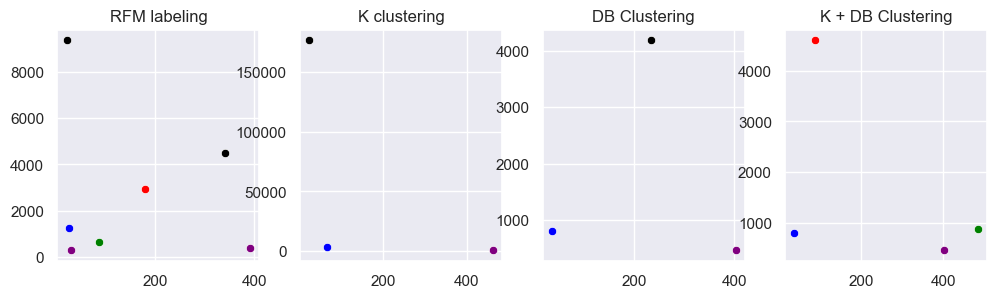

In [53]:
data_rfm_grouped = data_rfm_clusters.groupby('RFM_Segment', as_index=False).agg({
    'Recency': 'mean', 
    'Frequency':'mean',
    'Monetary': 'mean'}).round(2)
data_rfm_grouped = data_rfm_grouped.rename(columns={'Recency':'Recency_mean', 'Frequency':'Frequency_mean', 'Monetary':'Monetary_mean'})
data_rfm_grouped['Frequency_type'] = pd.qcut(data_rfm_grouped['Frequency_mean'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_K = data_rfm_clusters.groupby('cluster_K', as_index=False).agg({
    'Recency': 'mean', 
    'Frequency':'mean',
    'Monetary': 'mean'}).round(2)
data_rfm_grouped_K = data_rfm_grouped_K.rename(columns={'Recency':'Recency_mean', 'Frequency':'Frequency_mean', 'Monetary':'Monetary_mean'})
data_rfm_grouped_K['Frequency_type'] = pd.qcut(data_rfm_grouped_K['Frequency_mean'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_DB = data_rfm_clusters.groupby('cluster_DB', as_index=False).agg({
    'Recency': 'mean', 
    'Frequency':'mean',
    'Monetary': 'mean'}).round(2)
data_rfm_grouped_DB = data_rfm_grouped_DB.rename(columns={'Recency':'Recency_mean', 'Frequency':'Frequency_mean', 'Monetary':'Monetary_mean'})
data_rfm_grouped_DB['Frequency_type'] = pd.qcut(data_rfm_grouped_DB['Frequency_mean'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_K_DB = data_rfm_clusters.groupby('K_DB', as_index=False).agg({
    'Recency': 'mean', 
    'Frequency':'mean',
    'Monetary': 'mean'}).round(2)
data_rfm_grouped_K_DB = data_rfm_grouped_K_DB.rename(columns={'Recency':'Recency_mean', 'Frequency':'Frequency_mean', 'Monetary':'Monetary_mean'})
data_rfm_grouped_K_DB['Frequency_type'] = pd.qcut(data_rfm_grouped_K_DB['Frequency_mean'],5, labels = [5, 4 , 3, 2, 1])

def color_F(f_type):
    colors = ['black', 'red', 'blue', 'green', 'purple']
    return colors[f_type - 1]


fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, c in enumerate(data_rfm_grouped['RFM_Segment']):
    X = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Monetary_mean'][i]
    f_type = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[0])
axes[0].set_title('RFM labeling')
for i, c in enumerate(data_rfm_grouped_K['cluster_K']):
    X = data_rfm_grouped_K[data_rfm_grouped_K['cluster_K'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped_K[data_rfm_grouped_K['cluster_K'] == c]['Monetary_mean'][i]
    f_type = data_rfm_grouped_K[data_rfm_grouped_K['cluster_K'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[1])
axes[1].set_title('K clustering')
for i, c in enumerate(data_rfm_grouped_DB['cluster_DB']):
    X = data_rfm_grouped_DB[data_rfm_grouped_DB['cluster_DB'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped_DB[data_rfm_grouped_DB['cluster_DB'] == c]['Monetary_mean'][i]
    f_type = data_rfm_grouped_DB[data_rfm_grouped_DB['cluster_DB'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[2])
axes[2].set_title('DB Clustering')
for i, c in enumerate(data_rfm_grouped_K_DB['K_DB']):
    X = data_rfm_grouped_K_DB[data_rfm_grouped_K_DB['K_DB'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped_K_DB[data_rfm_grouped_K_DB['K_DB'] == c]['Monetary_mean'][i]
    if Y != data_rfm_grouped_K_DB['Monetary_mean'].max():
        f_type = data_rfm_grouped_K_DB[data_rfm_grouped_K_DB['K_DB'] == c]['Frequency_type'][i]
        sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[3])
axes[3].set_title('K + DB Clustering')

The left graph represents the clustering of the points based on the emperical metric (the number of bins was more or less random). We see that based on the Recency and Monetary the three points in the left lower corner can be united into a single group. Similarly the two points in the right lower corner of the K+DB graph can be united. The the clsterization is rather similar. However, we have removed the points with the extreme values of Monetary that are predicted as a single class by the Kmeans method. By comparing with RFM labeling method it seems that the DB clustering and K+DB clustering are rather similar. The RFM Lableing has an extra point with a large Monetary over 8000. However, we should keep in mind that the results in the RFM lableing can change for a different number of bins. There we simply used the emprical buisness oriented reference

Text(0.5, 1.0, 'K + DB Clustering')

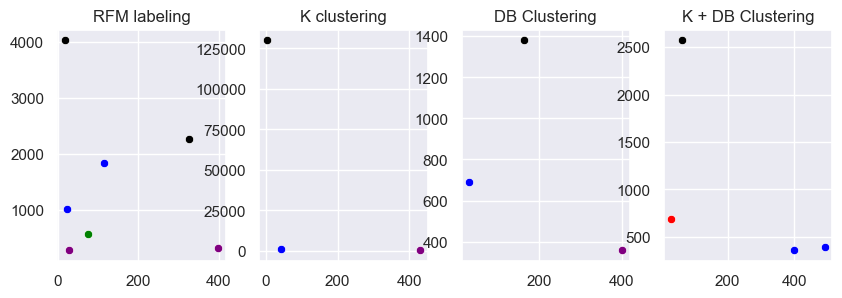

In [54]:
data_rfm_grouped_med = data_rfm_clusters.groupby('RFM_Segment', as_index=False).agg({
    'Recency': 'median', 
    'Frequency':'median',
    'Monetary': 'median'}).round(2)
data_rfm_grouped_med = data_rfm_grouped_med.rename(columns={'Recency':'Recency_med', 'Frequency':'Frequency_med', 'Monetary':'Monetary_med'})
data_rfm_grouped_med['Frequency_type'] = pd.qcut(data_rfm_grouped_med['Frequency_med'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_K_med= data_rfm_clusters.groupby('cluster_K', as_index=False).agg({
    'Recency': 'median', 
    'Frequency':'median',
    'Monetary': 'median'}).round(2)
data_rfm_grouped_K_med = data_rfm_grouped_K_med.rename(columns={'Recency':'Recency_med', 'Frequency':'Frequency_med', 'Monetary':'Monetary_med'})
data_rfm_grouped_K_med['Frequency_type'] = pd.qcut(data_rfm_grouped_K_med['Frequency_med'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_DB_med = data_rfm_clusters.groupby('cluster_DB', as_index=False).agg({
    'Recency': 'median', 
    'Frequency':'median',
    'Monetary': 'median'}).round(2)
data_rfm_grouped_DB_med = data_rfm_grouped_DB_med.rename(columns={'Recency':'Recency_med', 'Frequency':'Frequency_med', 'Monetary':'Monetary_med'})
data_rfm_grouped_DB_med['Frequency_type'] = pd.qcut(data_rfm_grouped_DB_med['Frequency_med'],5, labels = [5, 4 , 3, 2, 1])
data_rfm_grouped_K_DB_med = data_rfm_clusters.groupby('K_DB', as_index=False).agg({
    'Recency': 'median', 
    'Frequency':'median',
    'Monetary': 'median'}).round(2)
data_rfm_grouped_K_DB_med = data_rfm_grouped_K_DB_med.rename(columns={'Recency':'Recency_med', 'Frequency':'Frequency_med', 'Monetary':'Monetary_med'})
data_rfm_grouped_K_DB_med['Frequency_type'] = pd.qcut(data_rfm_grouped_K_DB_med['Frequency_med'], 3, labels = [3, 2, 1])


def color_F(f_type):
    colors = ['black', 'red', 'blue', 'green', 'purple']
    return colors[f_type - 1]


fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i, c in enumerate(data_rfm_grouped_med['RFM_Segment']):
    X = data_rfm_grouped_med[data_rfm_grouped_med['RFM_Segment'] == c]['Recency_med'][i]
    Y = data_rfm_grouped_med[data_rfm_grouped_med['RFM_Segment'] == c]['Monetary_med'][i]
    f_type = data_rfm_grouped_med[data_rfm_grouped_med['RFM_Segment'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[0])
axes[0].set_title('RFM labeling')
for i, c in enumerate(data_rfm_grouped_K_med['cluster_K']):
    X = data_rfm_grouped_K_med[data_rfm_grouped_K_med['cluster_K'] == c]['Recency_med'][i]
    Y = data_rfm_grouped_K_med[data_rfm_grouped_K_med['cluster_K'] == c]['Monetary_med'][i]
    f_type = data_rfm_grouped_K_med[data_rfm_grouped_K_med['cluster_K'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[1])
axes[1].set_title('K clustering')
for i, c in enumerate(data_rfm_grouped_DB_med['cluster_DB']):
    X = data_rfm_grouped_DB_med[data_rfm_grouped_DB_med['cluster_DB'] == c]['Recency_med'][i]
    Y = data_rfm_grouped_DB_med[data_rfm_grouped_DB_med['cluster_DB'] == c]['Monetary_med'][i]
    f_type = data_rfm_grouped_DB_med[data_rfm_grouped_DB_med['cluster_DB'] == c]['Frequency_type'][i]
    sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[2])
axes[2].set_title('DB Clustering')
for i, c in enumerate(data_rfm_grouped_K_DB_med['K_DB']):
    X = data_rfm_grouped_K_DB_med[data_rfm_grouped_K_DB_med['K_DB'] == c]['Recency_med'][i]
    Y = data_rfm_grouped_K_DB_med[data_rfm_grouped_K_DB_med['K_DB'] == c]['Monetary_med'][i]
    if Y != data_rfm_grouped_K_DB_med['Monetary_med'].max():
        f_type = data_rfm_grouped_K_DB_med[data_rfm_grouped_K_DB_med['K_DB'] == c]['Frequency_type'][i]
        sns.scatterplot(x=[X],y=[Y],color=color_F(f_type),ax=axes[3])
axes[3].set_title('K + DB Clustering')

In [55]:
data_rfm_grouped_K_DB

,K_DB,Recency_mean,Frequency_mean,Monetary_mean,Frequency_type
0,00,486.18,2.47,880.04,4
1,02,402.69,1.52,463.34,5
2,10,85.38,10.50,4596.25,2
3,11,35.22,2.73,809.07,3
4,20,23.55,143.14,176557.66,1


In [56]:
data_rfm_grouped

,RFM_Segment,Recency_mean,Frequency_mean,Monetary_mean,Frequency_type
0,At-Risk,392.42,1.53,395.85,5
1,Can't Lose Them,340.89,8.91,4478.21,1
2,Champions,20.27,17.12,9354.32,1
3,Lost,178.89,5.80,2953.13,2
4,Loyal Customers,24.74,4.05,1273.84,3
5,Potential Loyalists,85.19,3.70,631.57,4
6,Recent Customers,28.71,1.33,294.17,5


In [57]:
for i, c in enumerate(data_rfm_grouped['RFM_Segment']):
    X = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Frequency_mean'][i]
    f_type = data_rfm_grouped[data_rfm_grouped['RFM_Segment'] == c]['Frequency_type'][i]
    print(X,Y)

392.42 1.53
340.89 8.91
20.27 17.12
178.89 5.8
24.74 4.05
85.19 3.7
28.71 1.33


In [58]:
data_rfm_clusters[data_rfm_clusters['cluster_DB'] == 0]['Monetary'].mean()

np.float64(4187.584408100487)

In [59]:
data_rfm_clusters[data_rfm_clusters['cluster_K'] == 2]['Monetary'].mean()

np.float64(176557.65681818177)

In [60]:
data_rfm_clusters.groupby('cluster_K', as_index=False).agg({'cluster_K':'count'})

,cluster_K
0,2009
1,3850
2,22


In [61]:
data_rfm_clusters.groupby('cluster_DB', as_index=False).agg({'cluster_DB':'count'})

,cluster_DB
0,3901
1,1418
2,562


In [62]:
data_rfm_clusters.groupby('RFM_Segment', as_index=False).agg({'RFM_Segment':'count'})

,RFM_Segment
0,2180
1,228
2,1294
3,944
4,458
5,460
6,317


In [63]:
data_rfm_grouped_K_DB

,K_DB,Recency_mean,Frequency_mean,Monetary_mean,Frequency_type
0,00,486.18,2.47,880.04,4
1,02,402.69,1.52,463.34,5
2,10,85.38,10.50,4596.25,2
3,11,35.22,2.73,809.07,3
4,20,23.55,143.14,176557.66,1


# 6. I want to check how classification changes if I only use Recency and Monetary

In [64]:
from sklearn.cluster import DBSCAN
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_rfm[['Recency','Monetary']])

dbscan = DBSCAN(eps=0.1, min_samples=50)
labels = dbscan.fit_predict(X_scaled)

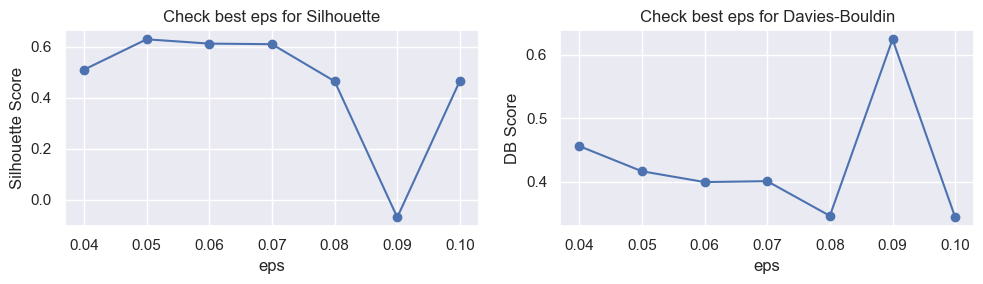

In [65]:
eps_s = [0.04,0.05,0.06,0.07,0.08,0.09,0.1]
min_samples_value = 50  # You fixed min_samples in this loop
sil_scores = []
db_scores = []

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for eps_i in eps_s:
    dbscan = DBSCAN(eps=eps_i, min_samples=50)
    labels = dbscan.fit_predict(X_scaled)

    core_samples_mask = labels != -1
    X_core = X_scaled[core_samples_mask]
    labels_core = labels[core_samples_mask]

    n_clusters = len(set(labels_core))

    if len(X_core) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X_core, labels_core)
        db_score = davies_bouldin_score(X_core, labels_core)
        sil_scores.append(silhouette)
        db_scores.append(db_score)
    else:
        sil_scores.append(np.nan)
        db_scores.append(np.nan)
        print(f"eps={eps_i}: Not enough clusters to compute scores.")

# Plotting
axes[0].plot(eps_s, sil_scores, marker='o')
axes[0].set_title('Check best eps for Silhouette')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')

axes[1].plot(eps_s, db_scores, marker='o')
axes[1].set_title('Check best eps for Davies-Bouldin')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('DB Score')

plt.tight_layout()
plt.show()

min_samp=15, : Not enough clusters to compute scores.
min_samp=20, : Not enough clusters to compute scores.
min_samp=30, : Not enough clusters to compute scores.
min_samp=40, : Not enough clusters to compute scores.
min_samp=400, : Not enough clusters to compute scores.
min_samp=450, : Not enough clusters to compute scores.
min_samp=500, : Not enough clusters to compute scores.


Text(0.5, 1.0, 'check the best min_samp for db')

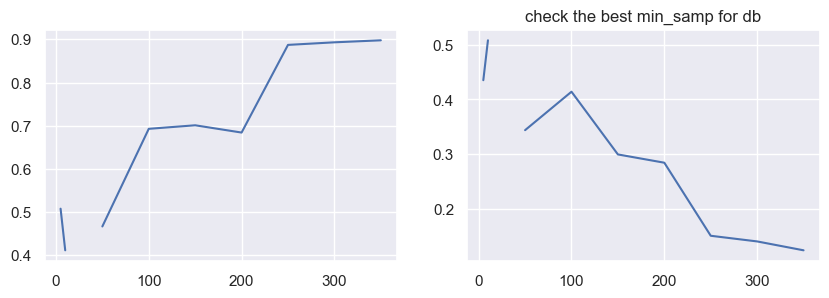

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sil_scores = []
db_scores = []
min_samp = [5,10,15,20,30,40,50,100,150,200,250,300,350,400,450,500]
for ms in min_samp:
    dbscan = DBSCAN(eps=0.1, min_samples=ms)
    labels = dbscan.fit_predict(X_scaled)

    core_samples_mask = labels != -1
    X_core = X_scaled[core_samples_mask]
    labels_core = labels[core_samples_mask]

    n_clusters = len(set(labels_core))

    if len(X_core) > 0 and n_clusters > 1:
        silhouette = silhouette_score(X_core, labels_core)
        db_score = davies_bouldin_score(X_core, labels_core)
        sil_scores.append(silhouette)
        db_scores.append(db_score)
    else:
        sil_scores.append(np.nan)
        db_scores.append(np.nan)
        print(f"min_samp={ms}, : Not enough clusters to compute scores.")

axes[0].plot(min_samp, sil_scores)
plt.title('check the best min_samp for sil')
axes[1].plot(min_samp, db_scores)
plt.title('check the best min_samp for db')

In [70]:
data_rfm

,Recency,Frequency,Monetary
Customer_ID,,,
12346.0,326,12,77556.46
12347.0,3,8,5633.32
12348.0,76,5,2019.40
12349.0,19,4,4428.69
12350.0,311,1,334.40
...,...,...,...
18283.0,4,22,2736.65
18284.0,432,1,461.68
18285.0,661,1,427.00


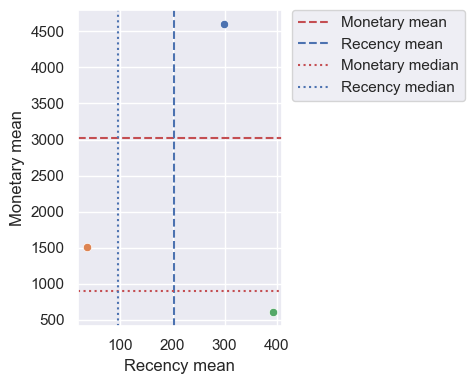

In [79]:
dbscan = DBSCAN(eps=0.1, min_samples=350)
scaled_data=scaler.fit_transform(data_rfm[['Recency','Monetary']])

cluster_labels_D = dbscan.fit_predict(scaled_data)
data_rfm_clusters['cluster_DB_2'] = cluster_labels_D + 1

data_rfm_grouped_DB_2 = data_rfm_clusters.groupby('cluster_DB_2', as_index=False).agg({
    'Recency': 'mean', 
    'Frequency':'mean',
    'Monetary': 'mean'}).round(2)
data_rfm_grouped_DB_2 = data_rfm_grouped_DB_2.rename(columns={'Recency':'Recency_mean', 'Frequency':'Frequency_mean', 'Monetary':'Monetary_mean'})
data_rfm_grouped_DB_2['Frequency_type'] = pd.qcut(data_rfm_grouped_DB_2['Frequency_mean'],5, labels = [5, 4 , 3, 2, 1])

plt.figure(figsize=(5,4))
plt.xlabel('Recency mean')
plt.ylabel('Monetary mean')
for i, c in enumerate(data_rfm_grouped_DB_2['cluster_DB_2']):
    X = data_rfm_grouped_DB_2[data_rfm_grouped_DB_2['cluster_DB_2'] == c]['Recency_mean'][i]
    Y = data_rfm_grouped_DB_2[data_rfm_grouped_DB_2['cluster_DB_2'] == c]['Monetary_mean'][i]
    sns.scatterplot(x=[X],y=[Y])

plt.axhline(y=data_rfm['Monetary'].mean(), color='r', linestyle='--', label='Monetary mean')
plt.axvline(x=data_rfm['Recency'].mean(), color='b', linestyle='--', label='Recency mean')
plt.axhline(y=data_rfm['Monetary'].median(), color='r', linestyle=':', label='Monetary median')
plt.axvline(x=data_rfm['Recency'].median(), color='b', linestyle=':',label='Recency median')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()  # Prevents clipping of labels
plt.show()


Cluster Analysis Results

The clustering yields nearly identical results when the Frequency score is excluded, indicating that customers effectively fall into one of three distinct segments:

1. Regular Customers – Moderate spending frequency with consistent but not exceptionally high monetary value.
2. Low-Value Inactive Customers – Generated minimal revenue and have not engaged with the service for an extended period.
3. High-Value Monetary, High-Value Frequency : Buyers – Contributed significant revenue but have not returned in a long time. This segment likely consists of wholesale purchasers who place large, infrequent orders. The high recency values can be attributed to the time required for wholesalers to resell their inventory before placing new orders.1>